In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
df = pd.read_csv('pv_data.csv')
df.head()

,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,WindComponentUat0,WindComponentVat0,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed
0,0.000000,1.000000,0.250553,0.425266,0.653892,0.654981,0.426538,0.897686,0.000000,0.968750,0.000000
1,0.142857,1.000000,0.250817,0.407160,0.750980,0.661824,0.434919,0.892039,0.000000,1.000000,0.000000
2,0.285714,1.000000,0.251081,0.544557,0.667997,0.597057,0.399884,0.831692,0.000000,1.000000,0.000000
3,0.428571,0.708461,0.379841,0.688942,0.657905,0.598159,0.406052,0.818583,0.057197,0.976562,0.035185
4,0.571429,0.642045,0.555848,0.761857,0.593752,0.559800,0.407030,0.728758,0.244397,0.703125,0.120988


In [3]:
df['power_normed'].interpolate(method='linear', inplace=True)
values = df.values
values.shape

(18805, 11)

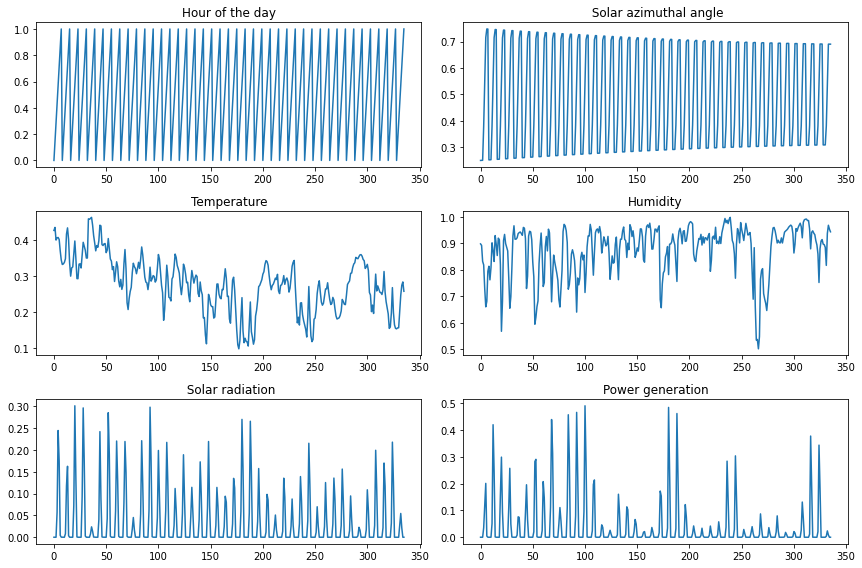

In [4]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(12,8))

axs[0,0].plot(values[0:336,0])
axs[0,0].set_title('Hour of the day')
axs[0,1].plot(values[0:336,2])
axs[0,1].set_title(' Solar azimuthal angle')
axs[1,0].plot(values[0:336,6])
axs[1,0].set_title('Temperature')
axs[1,1].plot(values[0:336,7])
axs[1,1].set_title('Humidity')
axs[2,0].plot(values[0:336,8])
axs[2,0].set_title(' Solar radiation')
axs[2,1].plot(values[0:336,10])
axs[2,1].set_title('Power generation')

fig.tight_layout()

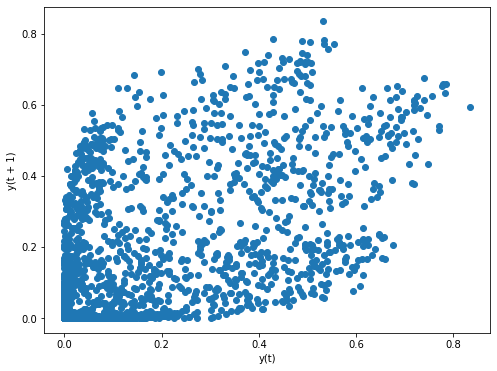

In [5]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
plt.figure(figsize = (8, 6))
series = df.iloc[2000:5000,10]
lag_plot(series)
pyplot.show()

<Figure size 576x432 with 0 Axes>

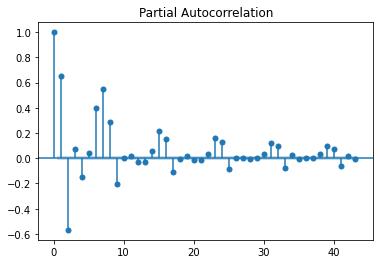

In [6]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize = (8, 6))
series1 = df.iloc[:,10]
plot_pacf(series1)
pyplot.show()

In [7]:
def wind_vel(arr1,arr2):
    velocity=np.sqrt(np.square(arr1)+np.square(arr2))
    return velocity
wind_velocity=wind_vel(values[:,3],values[:,4])
df.insert(loc=3, column='wind_velocity', value=wind_velocity)
print(df.shape)
df.head()

(18805, 12)


,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,wind_velocity,WindComponentUat0,WindComponentVat0,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed
0,0.000000,1.000000,0.250553,0.780017,0.425266,0.653892,0.654981,0.426538,0.897686,0.000000,0.968750,0.000000
1,0.142857,1.000000,0.250817,0.854255,0.407160,0.750980,0.661824,0.434919,0.892039,0.000000,1.000000,0.000000
2,0.285714,1.000000,0.251081,0.861836,0.544557,0.667997,0.597057,0.399884,0.831692,0.000000,1.000000,0.000000
3,0.428571,0.708461,0.379841,0.952618,0.688942,0.657905,0.598159,0.406052,0.818583,0.057197,0.976562,0.035185
4,0.571429,0.642045,0.555848,0.965903,0.761857,0.593752,0.559800,0.407030,0.728758,0.244397,0.703125,0.120988


In [8]:
dfn=df.drop(['WindComponentUat0', 'WindComponentVat0'], axis=1)
print(dfn.shape)
dfn.head()

(18805, 10)


,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,wind_velocity,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed
0,0.000000,1.000000,0.250553,0.780017,0.654981,0.426538,0.897686,0.000000,0.968750,0.000000
1,0.142857,1.000000,0.250817,0.854255,0.661824,0.434919,0.892039,0.000000,1.000000,0.000000
2,0.285714,1.000000,0.251081,0.861836,0.597057,0.399884,0.831692,0.000000,1.000000,0.000000
3,0.428571,0.708461,0.379841,0.952618,0.598159,0.406052,0.818583,0.057197,0.976562,0.035185
4,0.571429,0.642045,0.555848,0.965903,0.559800,0.407030,0.728758,0.244397,0.703125,0.120988


In [9]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

In [44]:
NON_DER = []
df_new = df_derived_by_shift(dfn, 16, NON_DER)

In [45]:
df_new = df_new.dropna()

In [46]:
df_new.head()

,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,wind_velocity,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed,...,power_normed_7,power_normed_8,power_normed_9,power_normed_10,power_normed_11,power_normed_12,power_normed_13,power_normed_14,power_normed_15,power_normed_16
16,0.000000,1.000000,0.254736,0.877641,0.496348,0.299962,0.853827,0.000000,0.546875,0.000000,...,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185,0.000000,0.000000,0.000000
17,0.142857,1.000000,0.254994,0.826589,0.549436,0.322894,0.919399,0.000000,0.421875,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185,0.000000,0.000000
18,0.285714,1.000000,0.255252,0.838903,0.549835,0.325424,0.913690,0.000000,0.906250,0.000000,...,0.051235,0.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185,0.000000
19,0.428571,0.718321,0.380589,0.891596,0.549915,0.361708,0.819946,0.072472,0.531250,0.158230,...,0.420576,0.051235,0.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185
20,0.571429,0.652176,0.555364,0.926402,0.476806,0.397277,0.567927,0.301037,1.000000,0.299383,...,0.243827,0.420576,0.051235,0.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988


In [47]:
df_new.columns.values

array(['hour_of_day', 'sunposition_thetaZ', 'sunposition_solarAzimuth',
       'wind_velocity', 'DewpointTemperatureAt0', 'TemperatureAt0',
       'RelativeHumidityAt0', 'SolarRadiationGlobalAt0',
       'TotalCloudCoverAt0', 'power_normed', 'hour_of_day_1',
       'hour_of_day_2', 'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5',
       'hour_of_day_6', 'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9',
       'hour_of_day_10', 'hour_of_day_11', 'hour_of_day_12',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15',
       'hour_of_day_16', 'sunposition_thetaZ_1', 'sunposition_thetaZ_2',
       'sunposition_thetaZ_3', 'sunposition_thetaZ_4',
       'sunposition_thetaZ_5', 'sunposition_thetaZ_6',
       'sunposition_thetaZ_7', 'sunposition_thetaZ_8',
       'sunposition_thetaZ_9', 'sunposition_thetaZ_10',
       'sunposition_thetaZ_11', 'sunposition_thetaZ_12',
       'sunposition_thetaZ_13', 'sunposition_thetaZ_14',
       'sunposition_thetaZ_15', 'sunposition_thetaZ_16',
    

In [48]:
corr=df_new.corr()
corr_arr=corr.values
print(corr_arr.shape)

(170, 170)


<AxesSubplot:>

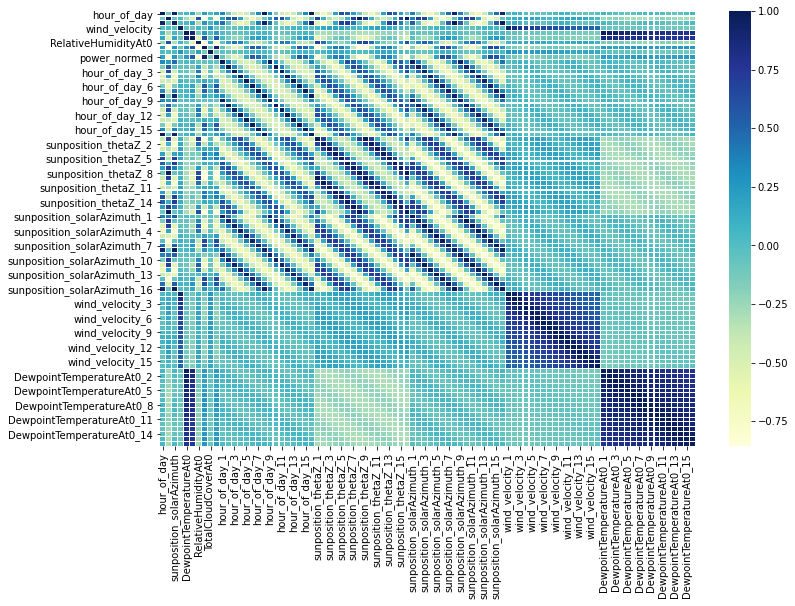

In [49]:
import seaborn as sns
f, ax = plt.subplots(figsize =(12,8))
sns.heatmap(corr.iloc[0:90,0:90], ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [50]:
X=df_new[['hour_of_day', 'sunposition_thetaZ', 'sunposition_solarAzimuth',
       'wind_velocity', 'DewpointTemperatureAt0', 'TemperatureAt0',
       'RelativeHumidityAt0', 'SolarRadiationGlobalAt0',
       'TotalCloudCoverAt0','power_normed_1',
       'power_normed_2', 'power_normed_3', 'power_normed_4',
       'power_normed_5', 'power_normed_6', 'power_normed_7',
       'power_normed_8', 'power_normed_9', 'power_normed_10',
       'power_normed_11', 'power_normed_12', 'power_normed_13',
       'power_normed_14', 'power_normed_15', 'power_normed_16']]

In [51]:
y=df_new[['power_normed']]

In [52]:
xval=X.values
xval.shape

(18789, 25)

In [53]:
yval=y.values

In [54]:
yval=yval.reshape((yval.shape[0],1))

In [55]:
yval.shape

(18789, 1)

In [56]:
data=np.concatenate((xval,yval), axis=1)
data.shape

(18789, 26)

In [57]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, .1))
# scaled = scaler.fit_transform(data)

In [58]:
scaled=data
print(scaled)

[[0.00000000e+00 1.00000000e+00 2.54735706e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42857143e-01 1.00000000e+00 2.54994196e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.85714286e-01 1.00000000e+00 2.55252335e-01 ... 3.51851850e-02
  0.00000000e+00 0.00000000e+00]
 ...
 [8.57142857e-01 1.00000000e+00 6.95528082e-01 ... 0.00000000e+00
  0.00000000e+00 2.46000000e-04]
 [1.00000000e+00 1.00000000e+00 6.95596228e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 3.04335219e-01 ... 0.00000000e+00
  0.00000000e+00 1.71932700e-03]]


In [59]:
# split into train and test sets
n_train_hours = len(scaled)-56
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, 0:216], train[:, -1]
test_X, test_y = test[:, 0:216], test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(18733, 26, 1) (18733,) (56, 26, 1) (56,)


In [60]:
test_y

array([0.        , 0.        , 0.00712293, 0.05157982, 0.01424585,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00638607, 0.10708952, 0.08301894, 0.000246  , 0.        ,
       0.        , 0.        , 0.        , 0.01007034, 0.09112434,
       0.05870274, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00785978, 0.10045783, 0.0567378 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01522833,
       0.11519492, 0.05772027, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00147371, 0.02603553, 0.0216144 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01522833, 0.02112316, 0.000246  , 0.        ,
       0.00171933])

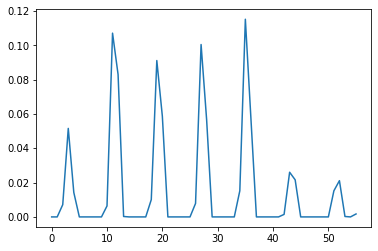

In [61]:
plt.plot(test_y)

In [62]:
train_y2=train_y.reshape(train_y.shape[0],1)
test_y2=test_y.reshape(test_y.shape[0],1)
n_features = 1
n_seq = 13
n_steps = 2
train_X2 = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))
test_X2= test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

(18733, 13, 2, 1) (18733, 1) (56, 13, 2, 1) (56, 1)


In [63]:
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from tensorflow.keras import regularizers
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 6,949
Trainable params: 6,949
Non-trainable params: 0
_________________________________________________________________


In [64]:
# fit model
history=model.fit(train_X2, train_y2, epochs=20, shuffle=False, validation_split = 0.2, batch_size = 16)

Epoch 1/20
937/937 [==============================] - 6s 6ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 2/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 3/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 4/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 5/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/20
937/937 [==============================] - 4s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 10/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0015

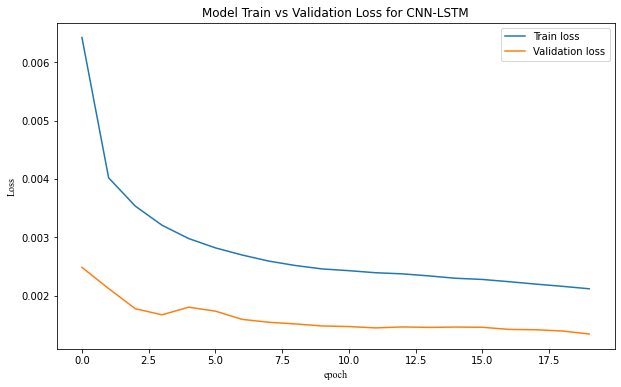

In [65]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    csfont = {'fontname':'Times New Roman'}
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for'+ model_name)
    plt.ylabel('Loss',**csfont)
    plt.xlabel('epoch',**csfont)
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history, ' CNN-LSTM')

In [66]:
# Make prediction
def prediction(model):
    prediction = model.predict(test_X2)
#     prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_CNNlstm = prediction(model)
prediction_CNNlstm

array([[ 1.07269734e-04],
       [-1.82177499e-03],
       [ 7.22255930e-03],
       [ 7.68376738e-02],
       [ 4.74905185e-02],
       [ 5.12240455e-03],
       [ 5.28697297e-03],
       [ 3.22194025e-03],
       [ 2.33815238e-03],
       [ 3.13788280e-03],
       [ 1.06342547e-02],
       [ 9.13685262e-02],
       [ 6.78880066e-02],
       [-9.53804702e-04],
       [-2.85721943e-03],
       [-1.06470659e-03],
       [-2.48406082e-04],
       [ 2.95687839e-03],
       [ 9.44672152e-03],
       [ 8.28889906e-02],
       [ 4.12608199e-02],
       [ 2.52259895e-03],
       [ 9.04779881e-04],
       [-9.51129943e-04],
       [-1.29978731e-03],
       [-4.17174771e-03],
       [ 8.09643790e-03],
       [ 1.01955220e-01],
       [ 6.87923133e-02],
       [-2.34593824e-03],
       [-1.86112896e-03],
       [-1.32789090e-03],
       [-2.31598690e-03],
       [-4.78518382e-03],
       [ 1.32960044e-02],
       [ 1.08561233e-01],
       [ 5.42676710e-02],
       [ 9.96034592e-04],
       [-1.1

In [67]:
prediction_CNNlstm.shape

(56, 1)

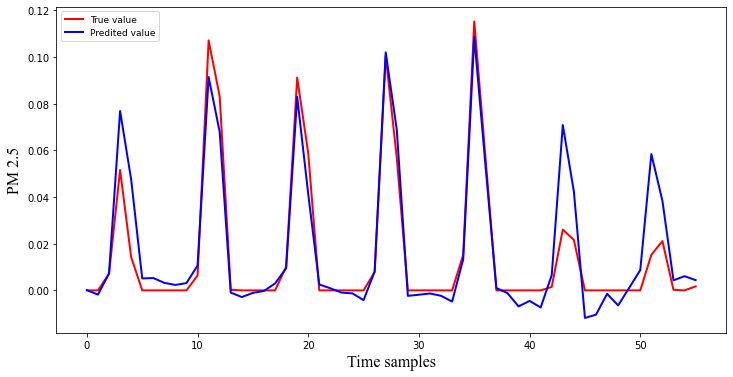

In [68]:
plt.figure(figsize=(12,6))
csfont = {'fontname':'Times New Roman'}
plt.ylabel('PM 2.5',fontsize=16,**csfont)
plt.xlabel('Time samples',fontsize=16,**csfont)
plt.plot(test_y2,c='r',linewidth=2)
plt.plot(prediction_CNNlstm,c='b',linewidth=2)
plt.legend(['True value','Predited value'], loc='upper left',fontsize=9)

In [70]:
def evaluate_prediction(predictions, actual, model_name):
    dif=predictions-actual
    errors = np.nan_to_num(dif, nan=0)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Square Error: {:.4f}'.format(mse))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute  Error: {:.4f}'.format(mae))
    return errors, mse, rmse, mae

errors, mse, rmse, mae= evaluate_prediction(test_y2,prediction_CNNlstm, 'Bidirectiona LSTM')

Bidirectiona LSTM:
Mean Square Error: 0.0001
Root Mean Square Error: 0.0121
Mean Absolute  Error: 0.0072


In [71]:
import numpy as np

def mape(actual,pred):
    act=[]
    prd=[]
    for i in range(len(actual)):
        if actual[i]==0 or pred[i]==0:
            pass
        else:
            act.append(actual[i])
            prd.append(pred[i])
        
    actual, pred = np.array(act), np.array(prd)
    mp=np.mean(np.abs((actual - pred) / actual))
    return mp

In [73]:
MAPE_scaled=mape(test_y,prediction_CNNlstm)
MAPE_scaled

19.469624443387403